What if we just used locally weighted linear regression for modeling nonlinear systems instead of using something like a neural network?

In [123]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [124]:
states = np.load('data_msd/states1-3-0.1-nonlinear.npy')
forces = np.load('data_msd/forces1-3-0.1-nonlinear.npy')

- states[t = 0] - states[t = T+1]
- forces[t = 0] - forces[t = T]

In [125]:
states_std = np.std(states,axis=0)
forces_std = np.std(forces,axis=0)

states_mean = np.array([0,0])
forces_mean = np.array([0])

Scale the states

In [126]:
states_norm = (states-states_mean)/states_std
forces_norm = (forces-forces_mean)/forces_std

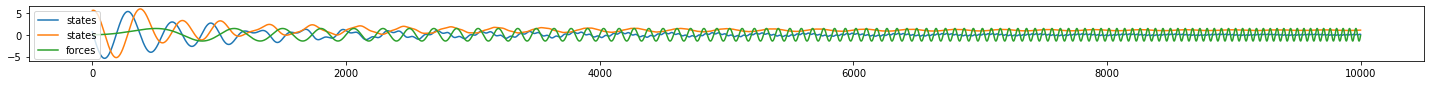

In [127]:
plt.figure(figsize=(25,1))
plt.plot(range(states_norm.shape[0]-1),states_norm[:-1],label = 'states')
plt.plot(range(forces_norm.shape[0]),forces_norm, label = 'forces')
plt.legend()
plt.show()

Prepare X and y

In [150]:
X = np.append(states_norm[:-1,:],forces_norm[:,np.newaxis],axis=1)
y = states_norm[1:,:]

In [164]:
samples = np.arange(X.shape[0])
random_sample = np.random.choice(samples,size=1000)

X = X[random_sample]
y = y[random_sample]

In [165]:
class LWLR:
    def __init__(self,X,y,tau):
        self.X = X
        self.y = y
        self.tau = tau

        if(self.X.shape[0] == self.X.size):
            self.X = self.X.reshape(-1,1)
            self.n = self.X.shape[1]
        
        self.m,self.n = self.X.shape
        
        self.X = np.insert(self.X,0,1,axis=1)
        
    def _get_w(self,x):
        w = np.exp(-(np.sum(((self.X-x)**2),axis=1)/(2*(self.tau**2))))
        return w
    
    def _get_theta(self,w):
        W = np.diag(w)
        theta = np.linalg.inv(self.X.T@W@self.X)@self.X.T@W@self.y
        return theta
    
    def _predict_point(self,x):
        w = self._get_w(x)
        theta = self._get_theta(w)
        prediction = x@theta
        return prediction
    
    def _predict_multiple(self,x):
        predictions = []
        for current_x in x:
            predictions.append(self._predict_point(current_x))
        predictions = np.array(predictions)
        return predictions
    
    def predict(self,x):
        if (x.size == x.shape[0]) and (self.n != 1):
            x = np.insert(x,0,1)
            prediction = self._predict_point(x)
        else:
            if (self.n == 1):
                x = x.reshape(-1,1)
            x = np.insert(x,0,1,axis=1)
            prediction = self._predict_multiple(x)
        return prediction

In [166]:
model = LWLR(X,y,1)

In [167]:
ITERATION = 200
tau = 1/100

initial_state = np.array([1,-1])/states_std
time = np.linspace(0,ITERATION*tau,ITERATION,endpoint=False)
#forces = np.ones(ITERATION)
forces = np.cos(time)/forces_std
#forces = np.zeros(ITERATION)

predicted_states = []
next_state = initial_state
for iteration in range(ITERATION):
    current_state = np.append(next_state,forces[iteration])
    next_state = model.predict(current_state)
    predicted_states.append(next_state)
    
print('completed')

completed


In [168]:
predicted_states = np.array(predicted_states)*states_std
forces = forces*forces_std

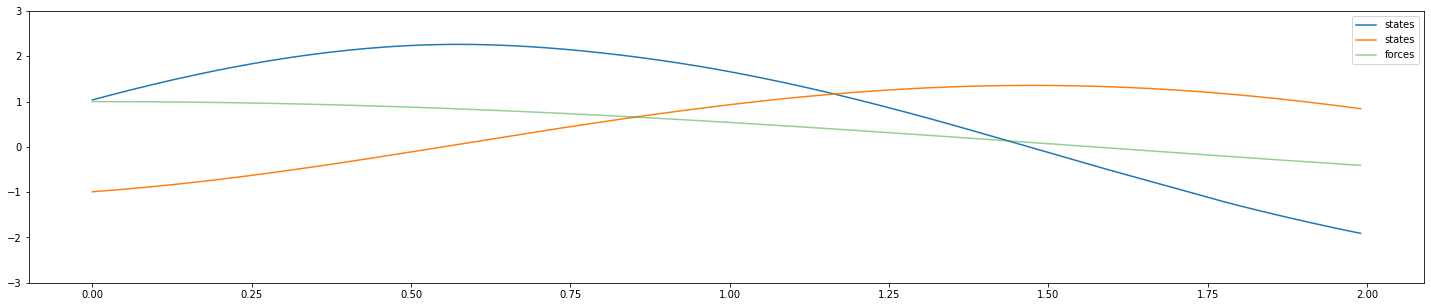

In [170]:
plt.figure(figsize=(25,5))
plt.plot(time,predicted_states,label='states')
plt.plot(time,forces,label='forces',alpha=0.5)
plt.ylim([-3,3])
plt.legend()
plt.show()


